In [1]:
# Load images and labels
import os
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt

# # Define the input directory
input_dir = 'C:/Users/odys_/Desktop/ML_winows_2/archive_small'

# Initialize lists to store images and labels
images = []
labels = []

# Loop through each folder (class name) in the input directory
for category in os.listdir(input_dir):
    category_path = os.path.join(input_dir, category)
    if os.path.isdir(category_path):  # Ensure it's a directory
        for file_name in os.listdir(category_path):
            if file_name.endswith('.jpeg') or file_name.endswith('.png'):  # Check for valid image files
                img_path = os.path.join(category_path, file_name)
                try:
                    # Open and preprocess the image
                    img = Image.open(img_path)
                    # img = img.resize((128, 128))  # Resize to 128x128
                    img_array = np.array(img)
                    
                    # Append the image and its label
                    images.append(img_array)
                    labels.append(category)  # Use the folder name as the label
                except Exception as e:
                    print(f"Error loading image {img_path}: {e}")

# Convert lists to numpy arrays
images = np.array(images)
labels = np.array(labels)

# Print some information about the loaded data
print(f"Loaded {len(images)} images.")
print(f"Image shape: {images[0].shape} ")
print(f"Labels: {np.unique(labels)}")


Loaded 600 images.
Image shape: (64, 64) 
Labels: ['AbdomenCT' 'BreastMRI' 'Hand' 'HeadCT']


In [2]:
from sklearn.model_selection import train_test_split

# Set random_state for reproducibility
random_state = 42

# Split into train and test only
X_train, X_test, y_train, y_test = train_test_split(
    images, labels, test_size=0.3, random_state=random_state, stratify=labels
)

print(f"Shape Train set: {X_train.shape}, labels: {y_train.shape}")
print(f"Shape Test set: {X_test.shape}, labels:{y_test.shape}")

Shape Train set: (420, 64, 64), labels: (420,)
Shape Test set: (180, 64, 64), labels:(180,)


In [3]:
# --- Preprocessing: Normalize images and encode labels ---
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Normalize pixel values
X_train_norm = X_train.astype('float32') / 255.0
X_test_norm = X_test.astype('float32') / 255.0

# Encode labels to integers, then to one-hot
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

y_train_cat = to_categorical(y_train_enc)
y_test_cat = to_categorical(y_test_enc)

print(f"Classes: {le.classes_}")
print(f"y_train_cat shape: {y_train_cat.shape}")

Classes: ['AbdomenCT' 'BreastMRI' 'Hand' 'HeadCT']
y_train_cat shape: (420, 4)


In [4]:
# --- Build the CNN model ---
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Expand dims for grayscale images
if len(X_train_norm.shape) == 3:
    X_train_norm = np.expand_dims(X_train_norm, -1)
    X_test_norm = np.expand_dims(X_test_norm, -1)

input_shape = X_train_norm.shape[1:]  # Now should be (64, 64, 1)
num_classes = y_train_cat.shape[1]

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

c:\Users\odys_\Desktop\ML_winows_2\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,625,092 (6.20 MB)

 Trainable params: 1,625,092 (6.20 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
# --- Train the model ---
history_non_tunned = model.fit(
    X_train_norm, y_train_cat,
    epochs=10,
    batch_size=32,
    validation_split=0.2
)

Epoch 1/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 314ms/step - accuracy: 0.5204 - loss: 1.0359 - val_accuracy: 0.9643 - val_loss: 0.1261
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 266ms/step - accuracy: 0.9385 - loss: 0.1431 - val_accuracy: 0.9762 - val_loss: 0.0919
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 275ms/step - accuracy: 0.9763 - loss: 0.0599 - val_accuracy: 1.0000 - val_loss: 0.0063
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 248ms/step - accuracy: 0.9863 - loss: 0.0473 - val_accuracy: 0.9881 - val_loss: 0.0294
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 259ms/step - accuracy: 0.9962 - loss: 0.0243 - val_accuracy: 1.0000 - val_loss: 0.0060
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 251ms/step - accuracy: 0.9983 - loss: 0.0316 - val_accuracy: 1.0000 - val_loss: 0.0024
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 247ms/step - accuracy: 1.0000 - loss: 0.0099 - val_accuracy: 1.0000 - val_loss: 0.0070
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 249ms/step - accuracy: 0.9986 - loss: 0.0059 - val_accuracy: 1.

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 1.0000 - loss: 0.0041
Test accuracy: 1.000


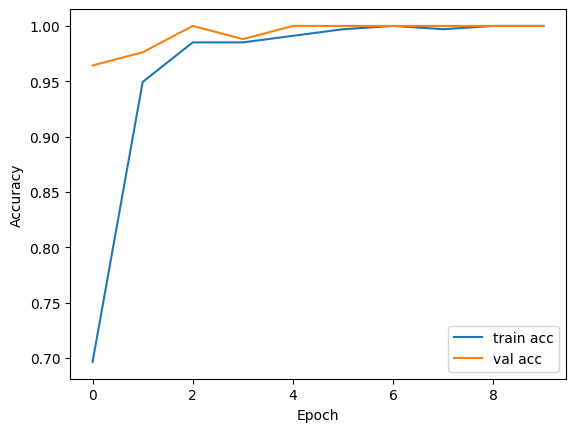

In [6]:
# --- Evaluate the model ---
test_loss, test_acc = model.evaluate(X_test_norm, y_test_cat)
print(f"Test accuracy: {test_acc:.3f}")

# Optional: Plot training history_non_tunned
plt.plot(history_non_tunned.history['accuracy'], label='train acc')
plt.plot(history_non_tunned.history['val_accuracy'], label='val acc')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


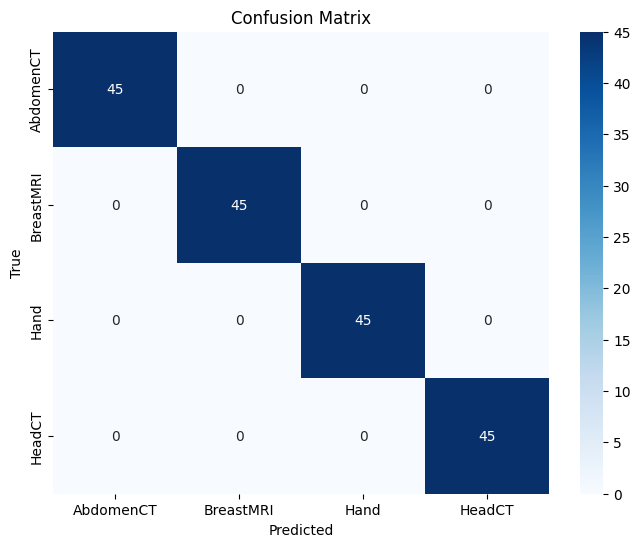

Classification Report:
              precision    recall  f1-score   support

   AbdomenCT       1.00      1.00      1.00        45
   BreastMRI       1.00      1.00      1.00        45
        Hand       1.00      1.00      1.00        45
      HeadCT       1.00      1.00      1.00        45

    accuracy                           1.00       180
   macro avg       1.00      1.00      1.00       180
weighted avg       1.00      1.00      1.00       180



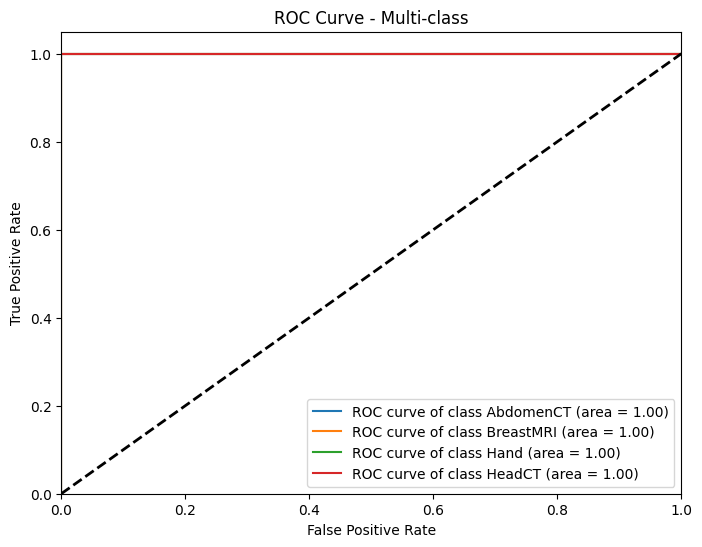

In [8]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize
import seaborn as sns

# Predict class probabilities and convert to class labels
y_pred_probs = model.predict(X_test_norm)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=le.classes_))

# ROC Curve for each class
y_test_bin = label_binarize(y_true, classes=range(len(le.classes_)))
n_classes = y_test_bin.shape[1]

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve of class {le.classes_[i]} (area = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Multi-class')
plt.legend(loc="lower right")
plt.show()

In [9]:
# --- Hyperparameter tuning with Keras Tuner ---
import keras_tuner as kt
from tensorflow.keras.optimizers import Adam

def build_model(hp):
    model = Sequential()
    model.add(Conv2D(
        filters=hp.Int('conv_1_filters', min_value=16, max_value=64, step=16),
        kernel_size=(3,3),
        activation='relu',
        input_shape=input_shape
    ))
    model.add(MaxPooling2D(2,2))
    model.add(Conv2D(
        filters=hp.Int('conv_2_filters', min_value=32, max_value=128, step=32),
        kernel_size=(3,3),
        activation='relu'
    ))
    model.add(MaxPooling2D(2,2))
    model.add(Flatten())
    model.add(Dense(
        units=hp.Int('dense_units', min_value=64, max_value=256, step=64),
        activation='relu'
    ))
    model.add(Dropout(rate=hp.Float('dropout', min_value=0.3, max_value=0.7, step=0.1)))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=1,
    directory='kt_dir',
    project_name='cnn_tuning'
)

tuner.search(
    X_train_norm, y_train_cat,
    epochs=5,
    validation_split=0.2,
    verbose=2
)

best_hp = tuner.get_best_hyperparameters(1)[0]
print("Best hyperparameters:")
for param in best_hp.values.keys():
    print(f"{param}: {best_hp.get(param)}")

# Build and train the best model
best_model = tuner.hypermodel.build(best_hp)
history_tunned = best_model.fit(
    X_train_norm, y_train_cat,
    epochs=10,
    batch_size=32,
    validation_split=0.2
)

Reloading Tuner from kt_dir\cnn_tuning\tuner0.json
Best hyperparameters:
conv_1_filters: 32
conv_2_filters: 96
dense_units: 256
dropout: 0.5
learning_rate: 0.001


c:\Users\odys_\Desktop\ML_winows_2\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 452ms/step - accuracy: 0.6356 - loss: 0.8701 - val_accuracy: 0.9881 - val_loss: 0.0575
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 433ms/step - accuracy: 0.9640 - loss: 0.1153 - val_accuracy: 0.9881 - val_loss: 0.0636
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 398ms/step - accuracy: 0.9782 - loss: 0.1772 - val_accuracy: 1.0000 - val_loss: 0.0058
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 393ms/step - accuracy: 0.9945 - loss: 0.0206 - val_accuracy: 1.0000 - val_loss: 0.0041
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 369ms/step - accuracy: 0.9973 - loss: 0.0087 - val_accuracy: 1.0000 - val_loss: 0.0053
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 409ms/step - accuracy: 0.9967 - loss: 0.0095 - val_accuracy: 1.0000 - val_loss: 0.0058
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 361ms/step - accuracy: 1.0000 - loss: 0.0094 - val_accuracy: 1.0000 - val_loss: 0.0011
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 377ms/step - accuracy: 1.0000 - loss: 0.0017 - val_accuracy: 1.

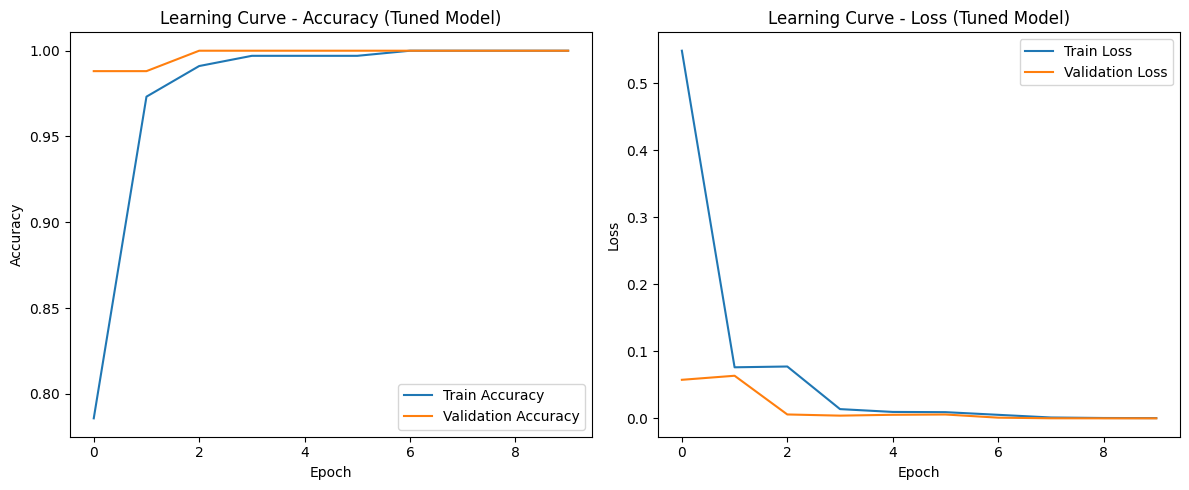

In [10]:
# Plot learning curve for the optimized (tuned) model
plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history_tunned.history['accuracy'], label='Train Accuracy')
plt.plot(history_tunned.history['val_accuracy'], label='Validation Accuracy')
plt.title('Learning Curve - Accuracy (Tuned Model)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history_tunned.history['loss'], label='Train Loss')
plt.plot(history_tunned.history['val_loss'], label='Validation Loss')
plt.title('Learning Curve - Loss (Tuned Model)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [11]:
def plot_learning_curve(history, title_suffix=""):
    """
    Plots the learning curve (accuracy and loss) for a Keras model training history.
    Args:
        history: Keras History object from model.fit().
        title_suffix: Optional string to append to plot titles.
    """
    import matplotlib.pyplot as plt

    plt.figure(figsize=(12,5))

    # Accuracy
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Learning Curve - Accuracy{title_suffix}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Learning Curve - Loss{title_suffix}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

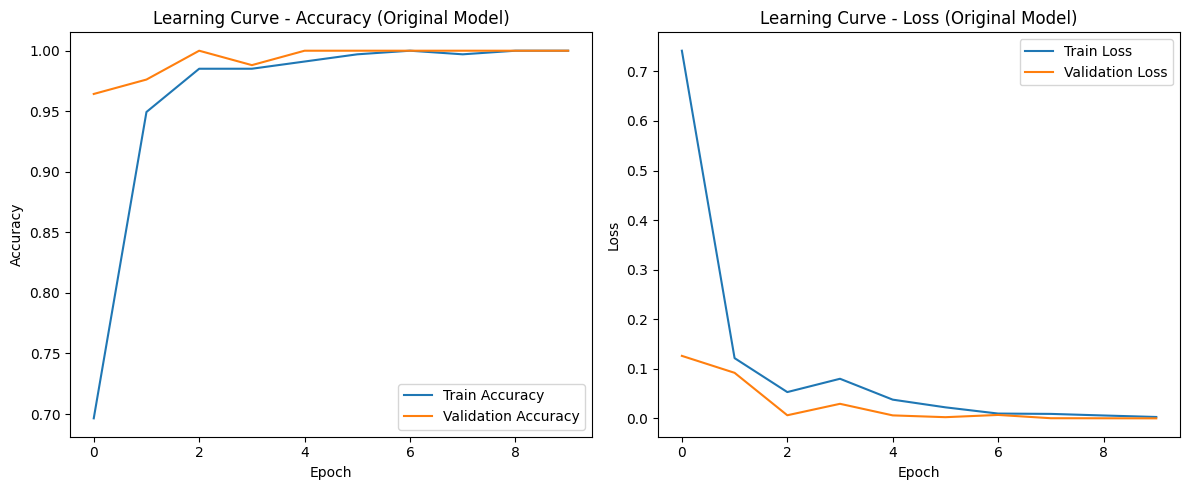

In [12]:
# For non-optimized model
plot_learning_curve(history_non_tunned, title_suffix=" (Original Model)")


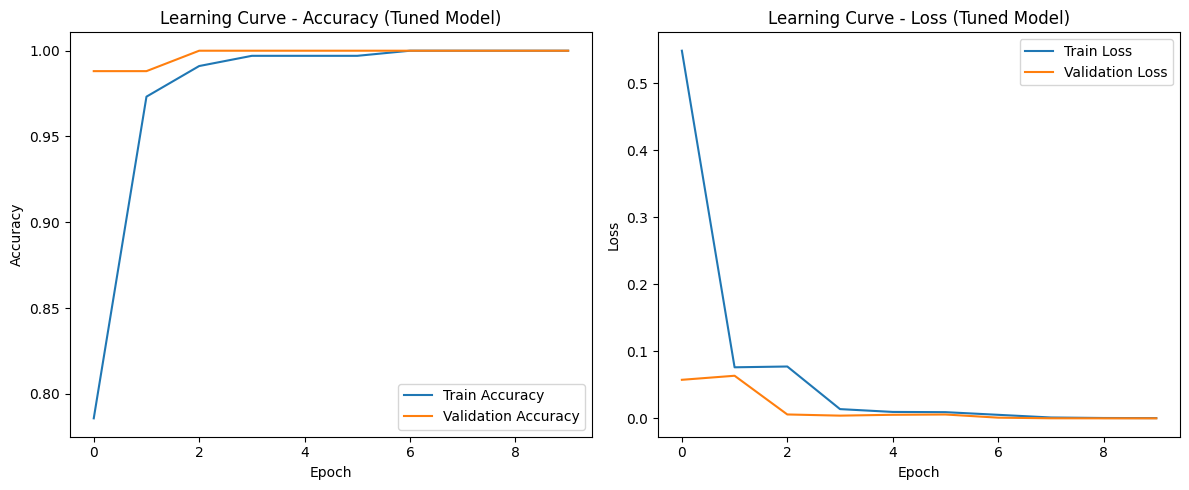

In [13]:

# For tuned model
plot_learning_curve(history_tunned, title_suffix=" (Tuned Model)")

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step


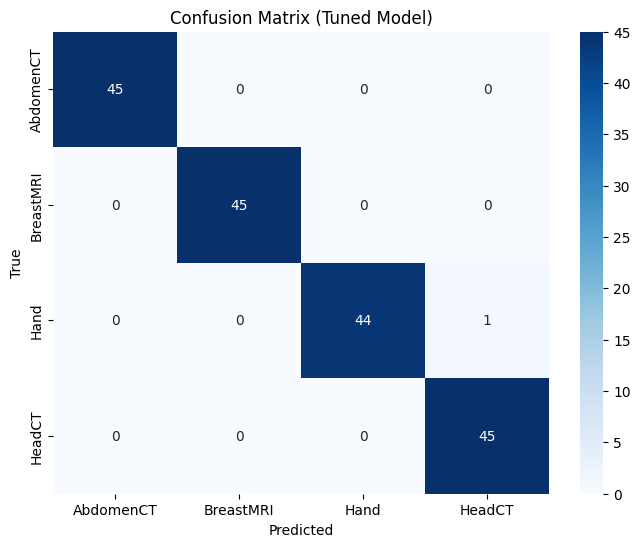

Classification Report (Tuned Model):
              precision    recall  f1-score   support

   AbdomenCT       1.00      1.00      1.00        45
   BreastMRI       1.00      1.00      1.00        45
        Hand       1.00      0.98      0.99        45
      HeadCT       0.98      1.00      0.99        45

    accuracy                           0.99       180
   macro avg       0.99      0.99      0.99       180
weighted avg       0.99      0.99      0.99       180



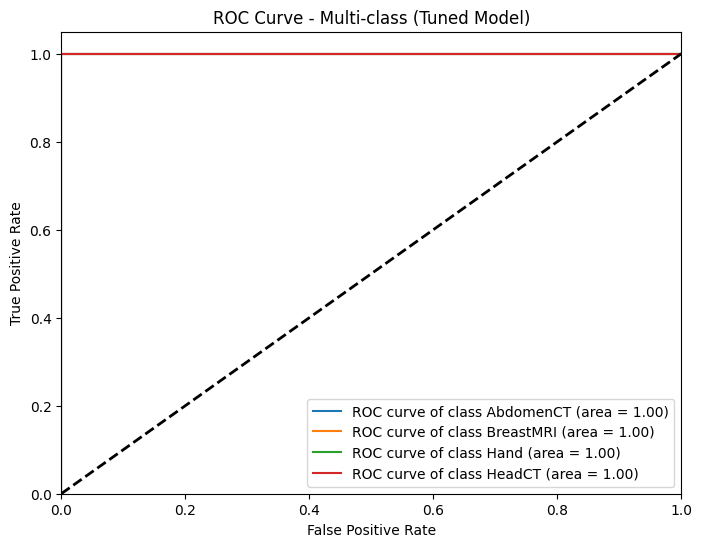

In [14]:
# --- Assessment of the tuned CNN model ---
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Predict class probabilities and convert to class labels
y_pred_probs = best_model.predict(X_test_norm)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Tuned Model)')
plt.show()

# Classification report
print("Classification Report (Tuned Model):")
print(classification_report(y_true, y_pred, target_names=le.classes_))

# ROC Curve for each class
y_test_bin = label_binarize(y_true, classes=range(len(le.classes_)))
n_classes = y_test_bin.shape[1]

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve of class {le.classes_[i]} (area = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Multi-class (Tuned Model)')
plt.legend(loc="lower right")
plt.show()

In [15]:
def assess_cnn_model(model, X_test, y_test_cat, label_encoder, title_suffix=""):
    """
    Assess a CNN model: prints confusion matrix, classification report, and ROC curves.
    Args:
        model: Trained Keras model.
        X_test: Normalized test images.
        y_test_cat: One-hot encoded test labels.
        label_encoder: Fitted LabelEncoder instance.
        title_suffix: Optional string to append to plot titles.
    """
    from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
    from sklearn.preprocessing import label_binarize
    import seaborn as sns
    import matplotlib.pyplot as plt
    import numpy as np

    # Predict class probabilities and convert to class labels
    y_pred_probs = model.predict(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_test_cat, axis=1)

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix{title_suffix}')
    plt.show()

    # Classification report
    print(f"Classification Report{title_suffix}:")
    print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

    # ROC Curve for each class
    y_test_bin = label_binarize(y_true, classes=range(len(label_encoder.classes_)))
    n_classes = y_test_bin.shape[1]

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(8, 6))
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label=f'ROC curve of class {label_encoder.classes_[i]} (area = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - Multi-class{title_suffix}')
    plt.legend(loc="lower right")
    plt.show()

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


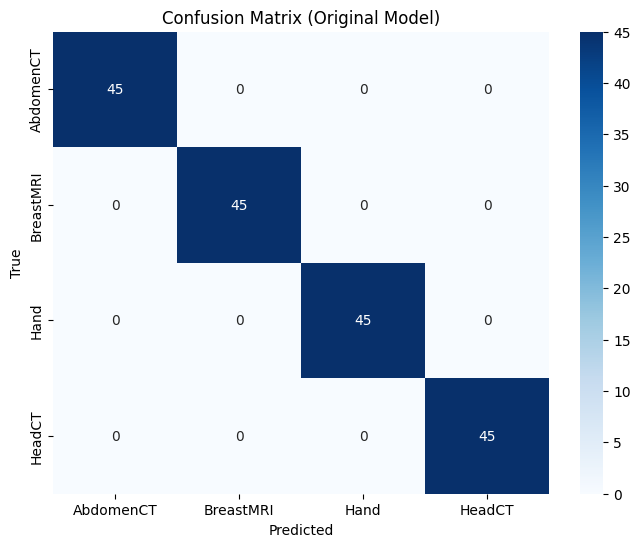

Classification Report (Original Model):
              precision    recall  f1-score   support

   AbdomenCT       1.00      1.00      1.00        45
   BreastMRI       1.00      1.00      1.00        45
        Hand       1.00      1.00      1.00        45
      HeadCT       1.00      1.00      1.00        45

    accuracy                           1.00       180
   macro avg       1.00      1.00      1.00       180
weighted avg       1.00      1.00      1.00       180



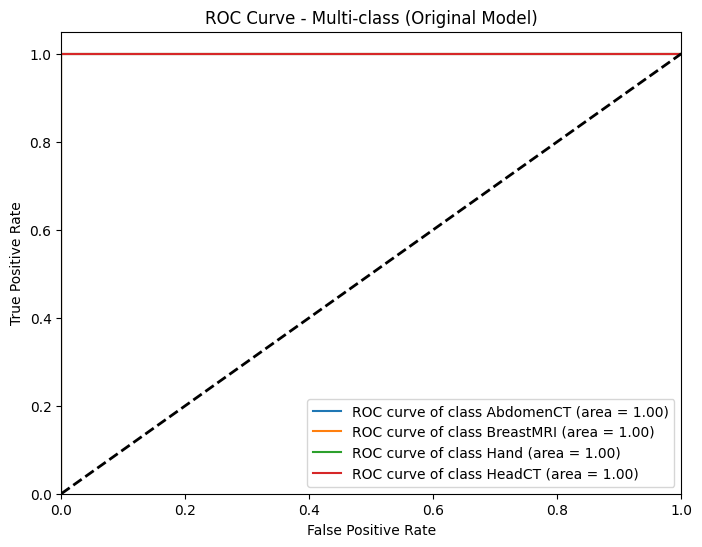

In [16]:
# For non-optimized model
assess_cnn_model(model, X_test_norm, y_test_cat, le, title_suffix=" (Original Model)")


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step


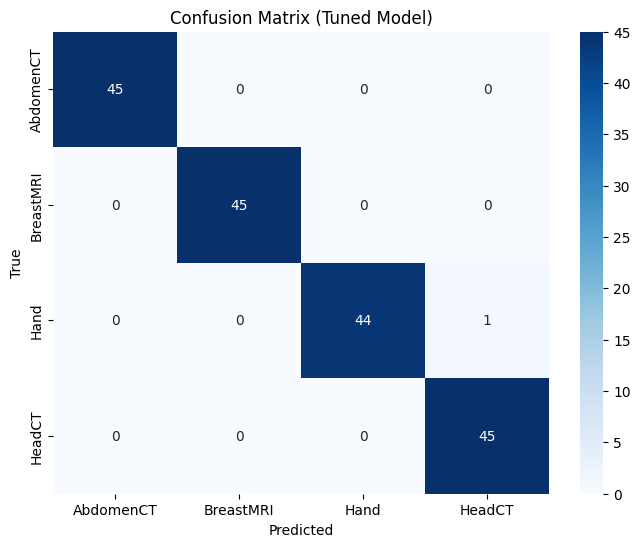

Classification Report (Tuned Model):
              precision    recall  f1-score   support

   AbdomenCT       1.00      1.00      1.00        45
   BreastMRI       1.00      1.00      1.00        45
        Hand       1.00      0.98      0.99        45
      HeadCT       0.98      1.00      0.99        45

    accuracy                           0.99       180
   macro avg       0.99      0.99      0.99       180
weighted avg       0.99      0.99      0.99       180



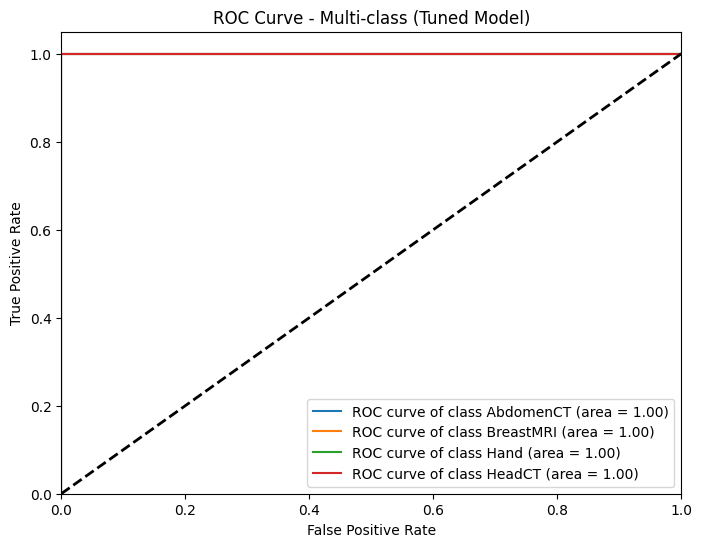

In [17]:

# For tuned model
assess_cnn_model(best_model, X_test_norm, y_test_cat, le, title_suffix=" (Tuned Model)")